In [6]:
import tensorflow as tf
import numpy as np
import h5py

from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, load_model


%matplotlib inline

In [2]:
def identity_block(X,f,filters):
  f1,f2,f3 = filters
  x_short = X
  X = Conv2D(filters=f1,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer='glorot_uniform')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=f2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer='glorot_uniform')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=f3,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer='glorot_uniform')(X)
  X = BatchNormalization(axis=3)(X)

  X = Add()([x_short,X])
  X = Activation('relu')(X)

  return X


In [3]:
def convolutional_block(X,f,filters,s=2):
  f1,f2,f3 = filters
  x_short = X
  X = Conv2D(filters=f1,kernel_size=(1,1),strides=(s,s),padding='valid',kernel_initializer='glorot_uniform')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=f2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer='glorot_uniform')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=f3,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer='glorot_uniform')(X)
  X = BatchNormalization(axis=3)(X)

  x_short = Conv2D(filters=f3,kernel_size=(1,1),strides=(s,s),padding='valid',kernel_initializer='glorot_uniform')(x_short)
  x_short = BatchNormalization(axis=3)(x_short)

  X = Add()([x_short,X])
  X = Activation('relu')(X)

  return X

In [4]:
def ResNet50(input_shape = (64,64,3),classes=6):
  X_input = Input(input_shape)

  X = ZeroPadding2D((3, 3))(X_input)
  X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = 'glorot_uniform')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  X = convolutional_block(X,f = 3,filters = [64, 64, 256],s=1)
  X = identity_block(X, 3, [64, 64, 256])
  X = identity_block(X, 3, [64, 64, 256])

  X = convolutional_block(X,f = 3,filters = [128,128,512],s=2)
  X = identity_block(X, 3, [128,128,512])
  X = identity_block(X, 3, [128,128,512])

  X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
  X = identity_block(X, 3, [256, 256, 1024])
  X = identity_block(X, 3, [256, 256, 1024])
  X = identity_block(X, 3, [256, 256, 1024])
  X = identity_block(X, 3, [256, 256, 1024])
  X = identity_block(X, 3, [256, 256, 1024])

  X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
  X = identity_block(X, 3, [512, 512, 2048])
  X = identity_block(X, 3, [512, 512, 2048])

  X = AveragePooling2D((2, 2))(X)
  X = Flatten()(X)
  X = Dense(units = classes, activation = 'softmax', kernel_initializer='he_uniform')(X)

  model = Model(inputs=X_input, outputs=X)
  return model



In [5]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

In [7]:
def load_dataset(path_to_train, path_to_test):
    train_dataset = h5py.File(path_to_train)
    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File(path_to_test)
    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])

    # y reshaped
    train_y = train_y.reshape((1, train_x.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))

    return train_x, train_y, test_x, test_y

In [9]:
train_x_orig, train_y_orig, test_x_orig, test_y_orig = load_dataset(path_to_train='/content/datasets/train_signs.h5',path_to_test='/content/datasets/test_signs.h5')

In [11]:
X_train = train_x_orig/255.
X_test = test_x_orig/255.

In [15]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)

In [16]:
Y_train = encoder.fit_transform(train_y_orig.T)
Y_test = encoder.fit_transform(test_y_orig.T)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
model = ResNet50()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics =['accuracy'])

In [20]:
history = model.fit(X_train,Y_train, validation_split=0.2, epochs = 100, batch_size=32)

Epoch 1/100
27/27 [==============================] - 50s 108ms/step - loss: 2.2287 - accuracy: 0.3796 - val_loss: 3.3631 - val_accuracy: 0.1528
Epoch 2/100
27/27 [==============================] - 1s 51ms/step - loss: 0.6591 - accuracy: 0.7708 - val_loss: 5.4832 - val_accuracy: 0.1528
Epoch 3/100
27/27 [==============================] - 1s 53ms/step - loss: 0.2870 - accuracy: 0.9155 - val_loss: 5.5095 - val_accuracy: 0.1806
Epoch 4/100
27/27 [==============================] - 1s 50ms/step - loss: 0.4232 - accuracy: 0.8657 - val_loss: 5.5767 - val_accuracy: 0.1528
Epoch 5/100
27/27 [==============================] - 1s 53ms/step - loss: 0.2816 - accuracy: 0.9109 - val_loss: 2.4618 - val_accuracy: 0.2454
Epoch 6/100
27/27 [==============================] - 2s 56ms/step - loss: 0.1877 - accuracy: 0.9421 - val_loss: 3.2181 - val_accuracy: 0.1759
Epoch 7/100
27/27 [==============================] - 1s 56ms/step - loss: 0.3089 - accuracy: 0.9178 - val_loss: 3.9752 - val_accuracy: 0.1528
Epoc

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
import matplotlib.pyplot as plt

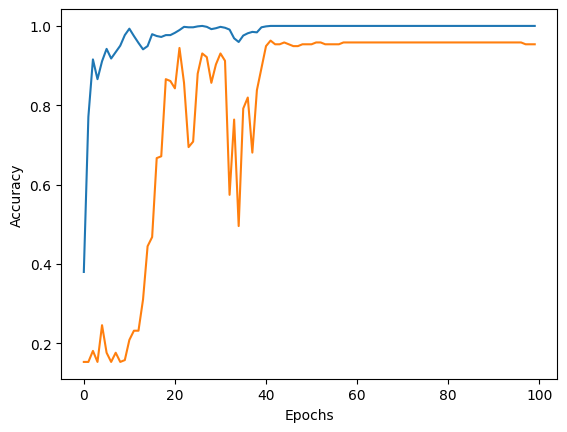

In [23]:
plt.plot(history.history['accuracy'],label='Train')
plt.plot(history.history['val_accuracy'],label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

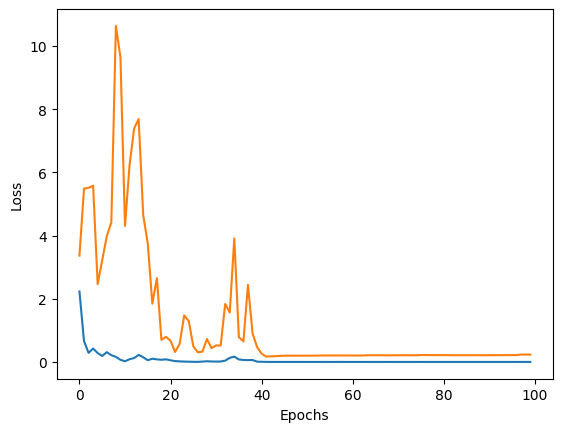

In [24]:
plt.plot(history.history['loss'],label='Train')
plt.plot(history.history['val_loss'],label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [25]:
model.evaluate(X_test,Y_test)

4/4 [==============================] - 0s 23ms/step - loss: 0.0628 - accuracy: 0.9750


[0.06275028735399246, 0.9750000238418579]